# Breeden-Litzenberger Formula to Calculate Stock Volatility

In [1]:
import numpy as np 
import scipy as sc
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

## Risk-neutral dynamics: Heston's Method
Underlying process: $dS_{t} = rS_{t}dt + \sqrt{v_{t}}S_{t}dW_{S,t}^\mathbb{Q}$

Variance process: $dv_{t} = \kappa(\theta - v_{t})dt + \sigma\sqrt{v_{t}}dW_{v,t}^\mathbb{Q}$

$- dW_{S,t}^\mathbb{Q} = $ Brownian motion of asset price

$- dW_{v,t}^\mathbb{Q} = $ Brownian motion of asset's price variance

$- \rho^\mathbb{Q} = $ correlation between $dW_{S,t}^\mathbb{Q}$ and $dW_{v,t}^\mathbb{Q}$

In [2]:
S0 = 100.0 # initial stock price
K = 150.0 # strike price
tau = 1.0 # time to maturity in years
r = 0.06 # annual risk-free rate

# Heston dependent parameters
kappa = 3 # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2 # long-term mean of variance under risk-neutral dynamics
v0 = 0.20**2 # initial variance under risk-neutral dynamics
rho = 0.98 # correlation between returns and variances under risk-neutral dynamics
sigma = 0.2 # volatility of volatility
lambd = 0 # risk premium of variance

2*kappa*theta, '>', sigma**2

(0.24000000000000005, '>', 0.04000000000000001)

## Breeden-Litzenberger Formula

Approximation of risk-neutral PDF using 2nd order finite difference:

$f_\mathbb{Q}(K, \tau) = e^{r\tau}\frac{\sigma^{2}C(K,\tau)}{\sigma K^{2}} \approx e^{r\tau}\frac{C(K+\Delta_{K,\tau})-2C(K,\tau)+C(K+\Delta_{K,\tau})}{(\Delta_{K})^{2}}$

### Characteristic Function

$\varphi(X_0, K, v_0,\tau; \phi) = e^{r \phi i \tau} S^{i \phi}[\frac{1-ge^{d\tau}}{1-g}]^{\frac{-2a}{\sigma^2}} exp[\frac{a \tau}{\sigma^2} (b_2 -\rho\sigma \phi i + d) + \frac{v_0}{\sigma^2}(b_2 -\rho\sigma\phi i + d)[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]]$ 

where: 

$d = \sqrt{(\rho\sigma \phi i - b)^2 + \sigma^2 (\phi i + \phi^2)}$

$g = \frac{b -\rho\sigma \phi i + d}{b -\rho\sigma \phi i - d}$

$a = \kappa \theta$

$ b = \kappa + \lambda$

Characteristic equation derivation: https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf

In [3]:
def heston_cf(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    a = kappa*theta
    b = kappa + lambd
    
    rspi = rho*sigma*phi*1j
    
    d = np.sqrt((rspi - b)**2 + (phi*1j+phi**2)*sigma**2)
    g = (b - rspi + d)/(b - rspi - d)
    
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j)*((1-g*np.exp(d*tau))/(1-g))**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*((1-np.exp(d*tau))/(1-g*np.exp(d*tau)))/sigma**2)
    
    return exp1*term2*exp2

def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 650
    dphi = umax/N # width
    
    for i in range(1,N): 
        phi = dphi * (2*i + 1)/2 # height at midpoint
        numerator = np.exp(r*tau)*heston_cf(phi-1j, *args) - K*heston_cf(phi, *args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi*numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [4]:
strikes = np.arange(60, 180, 1.0)
option_prices = heston_price_rec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)

option_prices

array([ 4.64739270e+01,  4.55718299e+01,  4.46674306e+01,  4.37607645e+01,
        4.28518461e+01,  4.19406635e+01,  4.10271756e+01,  4.01113140e+01,
        3.91929914e+01,  3.82721165e+01,  3.73486149e+01,  3.64224539e+01,
        3.54936701e+01,  3.45623948e+01,  3.36288777e+01,  3.26935044e+01,
        3.17568082e+01,  3.08194742e+01,  2.98823366e+01,  2.89463697e+01,
        2.80126732e+01,  2.70824530e+01,  2.61569989e+01,  2.52376611e+01,
        2.43258254e+01,  2.34228885e+01,  2.25302359e+01,  2.16492201e+01,
        2.07811419e+01,  1.99272346e+01,  1.90886500e+01,  1.82664484e+01,
        1.74615898e+01,  1.66749292e+01,  1.59072132e+01,  1.51590784e+01,
        1.44310530e+01,  1.37235584e+01,  1.30369128e+01,  1.23713359e+01,
        1.17269544e+01,  1.11038075e+01,  1.05018536e+01,  9.92097674e+00,
        9.36099342e+00,  8.82165911e+00,  8.30267494e+00,  7.80369403e+00,
        7.32432766e+00,  6.86415108e+00,  6.42270903e+00,  5.99952086e+00,
        5.59408535e+00,  

### Second-order finite difference approximation

In [5]:
prices = pd.DataFrame([strikes, option_prices]).transpose()
prices.columns = ['strike', 'price']
prices['curvature'] = (-2*prices['price'] + prices['price'].shift(1) + prices['price'].shift(-1)) / 1**2

Text(0.5, 1.0, 'Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

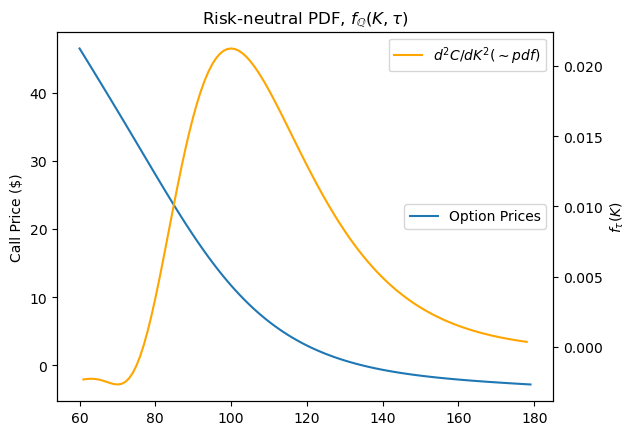

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
ax2 = ax.twinx()

ax.plot(strikes, option_prices, label='Option Prices')
ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')

ax.legend(loc="center right")
ax2.legend(loc="upper right")
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

## Comparison with QuantLib Heston Model

from: https://quant.stackexchange.com/questions/57827/computing-the-probability-density-function-pdf-for-the-heston-model

Text(0.5, 1.0, 'QuantLib: Risk-neutral PDF, $f_\\mathbb{Q}(K, \\tau)$')

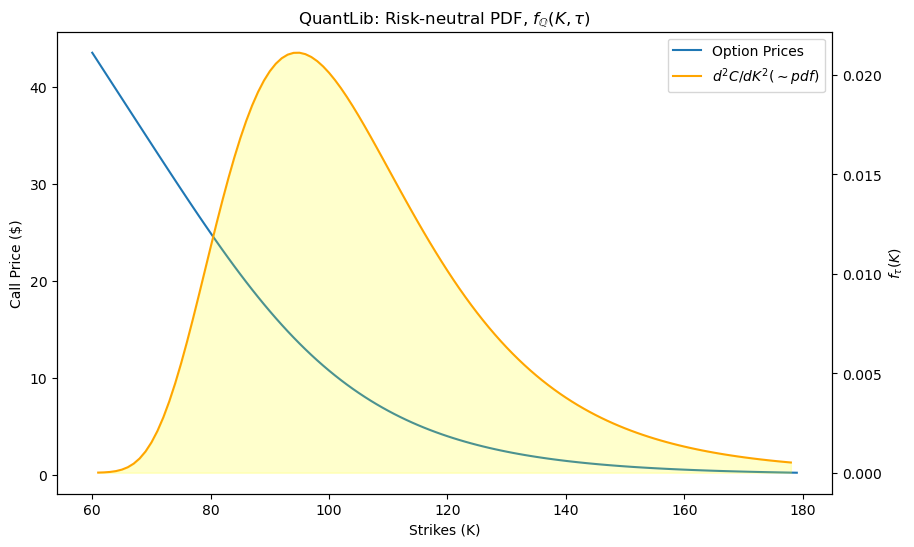

In [8]:
import QuantLib as ql
today = ql.Date(29, 9, 2024)
expiry_date = today + ql.Period(int(365*tau), ql.Days)

# Setting up discount curve
risk_free_curve = ql.FlatForward(today, r, ql.Actual365Fixed())
flat_curve = ql.FlatForward(today, 0.0, ql.Actual365Fixed())
riskfree_ts = ql.YieldTermStructureHandle(risk_free_curve)
dividend_ts = ql.YieldTermStructureHandle(flat_curve)

# Setting up a Heston model
heston_process = ql.HestonProcess(riskfree_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(S0)), v0, kappa, theta, sigma, rho)
heston_model = ql.HestonModel(heston_process)
heston_handle = ql.HestonModelHandle(heston_model)
heston_vol_surface = ql.HestonBlackVolSurface(heston_handle)

# Now doing some pricing and curvature calculations
vols = [heston_vol_surface.blackVol(tau, x) for x in strikes]

option_prices1 = []
for strike in strikes:
    option = ql.EuropeanOption( ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.EuropeanExercise(expiry_date))

    heston_engine = ql.AnalyticHestonEngine(heston_model)
    option.setPricingEngine(heston_engine)

    option_prices1.append(option.NPV())

prices = pd.DataFrame([strikes, option_prices, option_prices1]).transpose()
prices.columns = ['strike', 'Rectangular Int','QuantLib']
prices['curvature'] = (-2 * prices['QuantLib'] + prices['QuantLib'].shift(1) + prices['QuantLib'].shift(-1)) / 1**2

# And plotting...
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.ylabel('Call Price ($)')
plt.xlabel('Strikes (K)')
ax2 = ax.twinx()
lns1 = ax.plot(strikes, option_prices1, label='Option Prices')
lns2 = ax2.plot(prices['strike'], prices['curvature'], label='$d^2C/dK^2 (\sim pdf)$', color='orange')
ax2.fill_between(prices['strike'], prices['curvature'], color='yellow', alpha=0.2)

# added these three lines
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# ax.legend(loc="center right")
# ax2.legend(loc="upper right")
plt.ylabel('$f_\\tau(K)$')
plt.title('QuantLib: Risk-neutral PDF, $f_\mathbb{Q}(K, \\tau)$')

In [9]:
# Differences 
mse = np.mean((option_prices - option_prices1)**2)
print('QuantLib vs Rectangular Intergration \n Mean Squared Error: ', mse)
prices.dropna()
prices.head(40)

QuantLib vs Rectangular Intergration 
 Mean Squared Error:  5.31435646240303


,strike,Rectangular Int,QuantLib,curvature
0,60.0,46.473927,43.494129,NaN
1,61.0,45.571830,42.552367,0.000007
2,62.0,44.667431,41.610613,0.000017
3,63.0,43.760764,40.668875,0.000039
4,64.0,42.851846,39.727176,0.000082
5,65.0,41.940664,38.785559,0.000156
6,66.0,41.027176,37.844097,0.000276
7,67.0,40.111314,36.902911,0.000457
8,68.0,39.192991,35.962182,0.000716
9,69.0,38.272116,35.022169,0.001068


In [10]:
inter = prices.dropna()

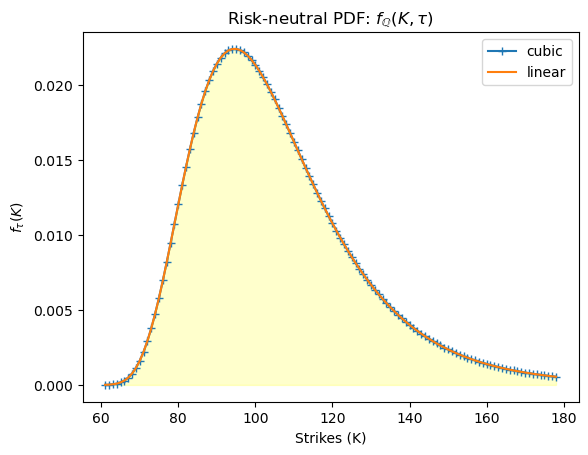

In [11]:
pdf = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'linear')
pdfc = sc.interpolate.interp1d(inter.strike, np.exp(r*tau)*inter.curvature, kind = 'cubic')

strikes = np.arange(61, 179, 1.0)

plt.plot(strikes, pdfc(strikes), '-+', label='cubic')
plt.plot(strikes, pdf(strikes), label='linear')
plt.fill_between(strikes, pdf(strikes), color='yellow', alpha=0.2)
plt.xlabel('Strikes (K)')
plt.ylabel('$f_\\tau(K)$')
plt.title('Risk-neutral PDF: $f_\mathbb{Q}(K, \\tau)$')
plt.legend()
plt.show()

### Cumulative distribution function

Text(0.5, 1.0, 'Risk-neutral CDF: $F_\\mathbb{Q}(K, \\tau)$')

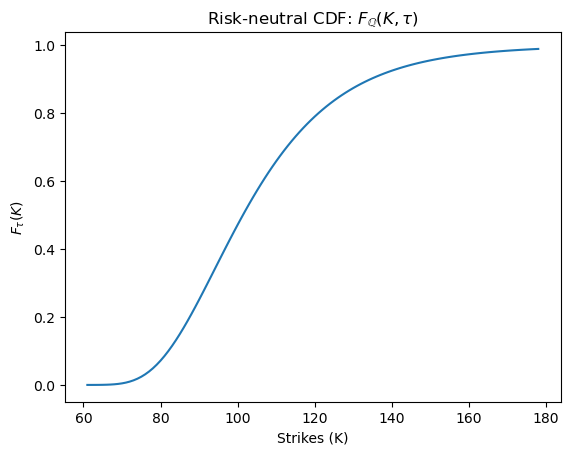

In [12]:
cdf = sc.interpolate.interp1d(inter.strike, np.cumsum(pdf(strikes)), kind = 'linear')

plt.plot(strikes, cdf(strikes))

plt.xlabel('Strikes (K)')
plt.ylabel('$F_\\tau(K)$')
plt.title('Risk-neutral CDF: $F_\mathbb{Q}(K, \\tau)$')

## Using risk-neutral PDF to price complex derivatives

For $f_\mathbb{Q}^{\tau} (S_{T})$ definted at $\tau$ time to expiry:

Call: $C(K,\tau) = e^{-r\tau} \int_{K}^{\infty}(S_{T} - K)f_\mathbb{Q}^{\tau} (S_{T}) dS_{T}$

Put: $P(K,\tau) = e^{-r\tau} \int_{K}^{\infty}(K - S_{T})f_\mathbb{Q}^{\tau} (S_{T}) dS_{T}$

In [14]:
def integrand_call(x, K):
    return (x-K)*pdf(x)

def integrand_put(x, K):
    return (K-x)*pdf(x)

calls, puts = [], []
for K in strikes: 
    call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)
    put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)
    
    call = np.exp(-r*tau)*call_int
    calls.append(call)
    put = put_int
    puts.append(put)

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_51484/859823011.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  call_int, err = sc.integrate.quad(integrand_call, K, 178, limit=1000, args=K)
/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_51484/859823011.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  put_int, err = sc.integrate.quad(integrand_put, 61, K, limit=1000, args=K)


In [15]:
rnd_prices = pd.DataFrame([strikes, calls, puts]).transpose()
rnd_prices.columns = ['strike', 'Calls','Puts']
rnd_prices.tail()

,strike,Calls,Puts
113,174.0,0.004409,68.107996
114,175.0,0.002437,69.094750
115,176.0,0.001064,70.082099
116,177.0,0.000261,71.070028
117,178.0,0.000000,72.058604
